In [1]:
import pandas as pd
from sklearn.datasets import make_blobs
from core.api import train_pipeline
from config.registries import MODEL_REGISTRY
from data.loaders import PandasDataLoader

In [2]:
# Generate sample data
X, _, centers = make_blobs(
    n_samples=3000,
    n_features=3,
    centers=5,
    cluster_std=1.0,
    random_state=0,
    return_centers=True
)
pd.DataFrame(X, columns=[f'x{i+1}' for i in range(3)]).to_parquet('data.parquet')

In [3]:
pd.read_parquet('data.parquet')

,x1,x2,x3
0,-2.803323,6.091965,0.560062
1,1.005863,2.250111,2.111326
2,-1.664214,8.968215,9.462399
3,0.215323,4.218356,1.265304
4,-1.287203,8.312072,8.308078
...,...,...,...
2995,1.211350,-0.541304,2.489197
2996,-2.149935,7.231925,0.423440
2997,1.123496,-0.304882,2.893082
2998,0.102689,10.071523,-9.534722


In [4]:
# Example configuration
base_config = {
  "data_source": "pandas",
  "preprocessing": {
    "normalizer": {
      "methods":{"x1": "zscore",
                "x2": "range",
                "x3": "minmax"},
        "columns": ["x1", "x2", "x3"]
    },
    "sampler": {
      "data_src": [
    "data.parquet",
    None
  ]
    }
  },
  "data_path": [
    "data.parquet",
    None
  ],
  "algorithm": "kmeans",
  "params": {
    "n_clusters": [
      3,
      5,
      7,
      10
    ],
    "init": [
      "k-means++",
      "random"
    ],
    "max_iter": [
      100,
      200
    ]
  },
  "metric": "silhouette",
  "output_path": "best_kmeans.joblib"
}

import json
with open('config.json', 'w') as f:
    json.dump(base_config, f, indent=2)

# Case 1

In [5]:
def analyze_results(model: object) -> None:
    """Display model training results."""
    print(f"Optimal parameters: {model.model.get_params()}")
    print(f"Inertia: {model.model.inertia_}")
    print("Cluster centroids:")
    for i, c in enumerate(model.model_data['centroids']):
        print(f"Cluster {i}: {c}")

def demo_pipeline(config: dict, algorithm: str = 'kmeans', spark=None) -> object:
    """Execute full training pipeline."""
    print(f"Available algorithms: {list(MODEL_REGISTRY.keys())}")
    print(f"\n{algorithm} parameters:")
    for param, desc in MODEL_REGISTRY[algorithm]['params_help'].items():
        print(f"  {param}: {desc}")

    model = train_pipeline(
        features_src=config['data_path'][0],
        similarity_src=config['data_path'][1],
        algorithm=algorithm,
        param_grid=config.get('params', {}),
        normalizer=config.get('preprocessing').get('normalizer'),
        sampler=config.get('preprocessing').get('sampler'),
        metric=config['metric'],
        optimizer=config.get('optimizer', 'grid'),
        spark = spark
    )
    if 'output_path' in config:
        model.save(config['output_path'])
    return model

In [6]:
# Execute manual pipeline
manual_model = demo_pipeline(base_config)
analyze_results(manual_model)

Available algorithms: ['kmeans', 'dbscan']

kmeans parameters:
  n_clusters: Number of clusters (positive integer)
  init: Initialization method [k-means++, random]
  max_iter: Maximum iterations (positive integer)
2025-05-15 15:22:12,208 - pattern - INFO - Loading data from data.parquet
2025-05-15 15:22:12,470 - pattern - INFO - Loading data from data.parquet
Optimal parameters: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 200, 'n_clusters': 3, 'n_init': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Inertia: 79.502236015088
Cluster centroids:
Cluster 0: [ 1.04526725 -0.01153692  0.38893041]
Cluster 1: [-1.21324701  0.07865641  0.64854556]
Cluster 2: [ 0.10958119 -0.06389016  0.63724483]


In [7]:
# Prediction demo
def predict_clusters(model: object, features: dict) -> None:
    """Make and display cluster predictions."""
    new_data = pd.DataFrame(features)
    predictions = model.predict(PandasDataLoader(new_data))
    print(f"Predicted clusters: {predictions.values}")

In [8]:
predict_clusters(manual_model, {
    'x1': [0.5, 1.5, 2.5],
    'x2': [0.3, 1.2, 2.1],
    'x3': [0.7, 3.5, 6.1],
})

Predicted clusters: [2 0 0]


In [9]:
pd.read_parquet('data.sample.parquet')

,x1,x2,x3
1801,0.288995,7.132011,9.805073
1190,1.812473,8.278505,-8.916242
1817,-1.910309,6.940629,10.092354
251,1.504932,5.547709,1.821432
2505,2.048908,7.907490,-9.122306
...,...,...,...
2497,0.766932,-1.057664,2.490394
787,-2.457972,5.802214,1.331991
2636,-0.342108,5.177075,-0.743316
2538,-3.091012,5.213179,1.152132


# Case 2

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from models.sklearn_cluster import SklearnKMeans
from preprocessing.normalizers import PandasNormalizer
from data.loaders import PandasDataLoader
from metrics.quality import SilhouetteScore
from optimization.strategies import GridSearch
import itertools

In [11]:
# 1. Loading data
loader = PandasDataLoader(
    data_src="data.parquet",
    normalizer=None,
    sampler=None
)
features, _ = loader.full_data()

2025-05-15 15:22:12,832 - pattern - INFO - Loading data from data.parquet


In [12]:
# 2. Preprocessing
normalizer = PandasNormalizer(
    methods={
        "x1": "zscore",
        "x2": "range", 
        "x3": "minmax"
    }
)
normalizer.fit(features)
normalized_features = normalizer.transform(features.copy())

In [13]:
# 3. Preparing parameters for search
param_grid = {
    'n_clusters': [3, 5, 7, 10],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200]
}

In [14]:
# 4. Manual Grid Search
best_score = -1
best_model = None
results = []

all_params = list(itertools.product(*param_grid.values()))

for params_values in all_params:
    params = dict(zip(param_grid.keys(), params_values))
    
    try:

        model = SklearnKMeans(params)
        
        model.fit(PandasDataLoader(data_src=normalized_features))
        
        labels = model.predict(PandasDataLoader(data_src=normalized_features))
        
        metric = SilhouetteScore()
        score = metric.calculate(
            data_loader=PandasDataLoader(data_src=normalized_features),
            labels=labels,
            model_data=model.model_data
        )
        
        results.append({
            'params': params,
            'score': score
        })
        
        if score > best_score:
            best_score = score
            best_model = model

    except Exception as e:
        print(f"Skipped {params}: {str(e)}")

In [15]:
# 5. Analysis results
df_results = pd.DataFrame(results)
print("Top 5 configurations:")
print(df_results.sort_values('score', ascending=False).head(5))

Top 5 configurations:
                                              params     score
2  {'n_clusters': 3, 'init': 'random', 'max_iter'...  0.407477
0  {'n_clusters': 3, 'init': 'k-means++', 'max_it...  0.407422
1  {'n_clusters': 3, 'init': 'k-means++', 'max_it...  0.407422
3  {'n_clusters': 3, 'init': 'random', 'max_iter'...  0.407422
4  {'n_clusters': 5, 'init': 'k-means++', 'max_it...  0.392425


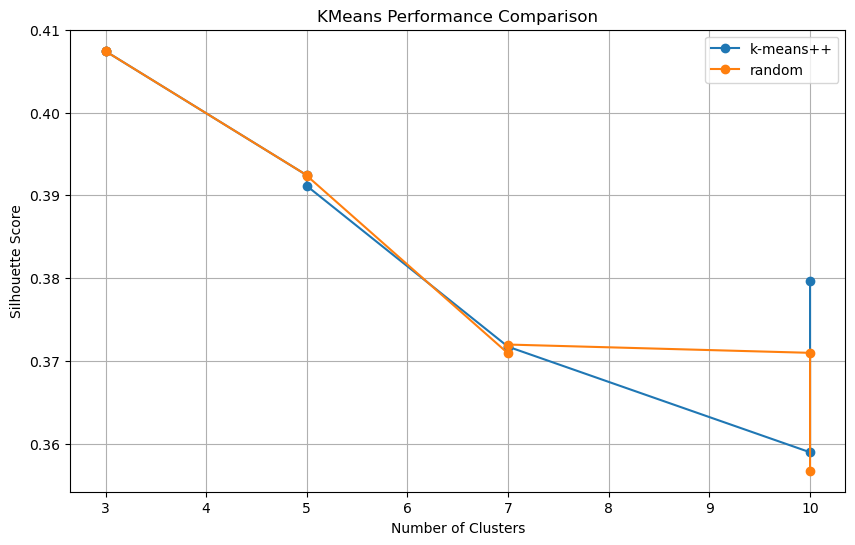

In [16]:
# 6. Visualization
plt.figure(figsize=(10, 6))
for init_method in ['k-means++', 'random']:
    subset = df_results[df_results['params'].apply(lambda x: x['init'] == init_method)]
    plt.plot(
        subset['params'].apply(lambda x: x['n_clusters']),
        subset['score'],
        marker='o',
        label=init_method
    )

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 7. Keeping the best model
if best_model:
    best_model.save("best_kmeans_custom.joblib")
    print(f"Best model saved with score: {best_score}")

Best model saved with score: 0.4074766262935989
